# Project 1
## Denoising EEG signals using LMS

In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
from pyedflib import highlevel
import matplotlib.pyplot as plt
import numpy as np
import padasip as pa
from scipy.signal import butter, filtfilt, welch

# interactive plots
# %matplotlib widget 
%matplotlib inline


Download sample file

!curl -o recordings/n6.edf https://physionet.org/content/capslpdb/1.0.0/n6.edf

In [3]:
signals, signal_headers, header = highlevel.read_edf(r"n6.edf copy")

Imprimo información del dataset

In [4]:
print('Lista de Canales en esta base de datos: \n')
for sh in signal_headers:
  #print(sh['label'], '  \t' ,sh['prefilter'],'  \tSample Rate:',sh['sample_rate'])
  print(sh)

Lista de Canales en esta base de datos: 

{'label': 'LOC-A1', 'dimension': 'uV', 'sample_frequency': 128.0, 'physical_max': 584.4729, 'physical_min': -582.193, 'digital_max': 2047, 'digital_min': -2048, 'prefilter': '', 'transducer': ''}
{'label': 'ROC-A2', 'dimension': 'uV', 'sample_frequency': 128.0, 'physical_max': 556.5395, 'physical_min': -559.264, 'digital_max': 2047, 'digital_min': -2048, 'prefilter': '', 'transducer': ''}
{'label': 'EMG-EMG', 'dimension': 'uV', 'sample_frequency': 128.0, 'physical_max': 564.3646, 'physical_min': -566.85, 'digital_max': 2047, 'digital_min': -2048, 'prefilter': '', 'transducer': ''}
{'label': 'C3-A2', 'dimension': 'uV', 'sample_frequency': 128.0, 'physical_max': 555.9782, 'physical_min': -556.793, 'digital_max': 2047, 'digital_min': -2048, 'prefilter': '', 'transducer': ''}
{'label': 'O2-A1', 'dimension': 'uV', 'sample_frequency': 128.0, 'physical_max': 560.6849, 'physical_min': -561.232, 'digital_max': 2047, 'digital_min': -2048, 'prefilter': ''

In [5]:
print("\nNúmero de canales:", len(signals))
for i, signal in enumerate(signals):
    print(f"Canal {signal_headers[i]['label']}: {len(signal)} muestras")
    print(f"duración (segundos): {len(signal) / signal_headers[i]['sample_frequency']}")



Número de canales: 8
Canal LOC-A1: 4048000 muestras
duración (segundos): 31625.0
Canal ROC-A2: 4048000 muestras
duración (segundos): 31625.0
Canal EMG-EMG: 4048000 muestras
duración (segundos): 31625.0
Canal C3-A2: 4048000 muestras
duración (segundos): 31625.0
Canal O2-A1: 4048000 muestras
duración (segundos): 31625.0
Canal ECG: 4048000 muestras
duración (segundos): 31625.0
Canal TAG: 4048000 muestras
duración (segundos): 31625.0
Canal THE: 4048000 muestras
duración (segundos): 31625.0


# Ver que paciente ni me conviene tomar según la señal que tenga cada uno

## Sueño REM
EOG (Electrooculograma): Presenta movimientos oculares rápidos y de gran amplitud. Verás picos y oscilaciones marcadas, a veces en ambos canales EOG (ROC-A2, LOC-A1).
EEG (Electroencefalograma): Muestra actividad de baja amplitud y alta frecuencia, similar a la vigilia. Predominan ondas theta y actividad rápida, sin ondas lentas ni complejos K.
EMG (Electromiograma): Hay atonía muscular, es decir, la señal EMG tiene muy baja amplitud (casi plana), indicando relajación muscular.

N6 - REM [s] 10640, 10700, 10820, 11060, 11090, 11210, 11420, 10820, 11090 (la mayoria por esta zona esta buena)

Las diferencias entre F3/F4 (frontales), C3/C4 (centrales) y O1/O2 (occipitales) pueden ser útiles para comparar patrones, pero para REM no hay un electrodo claramente superior; puedes usar cualquiera para ver la actividad rápida y baja amplitud.

## Etapa S3/S4 (Sueño NREM 3, sueño profundo):

EEG: Predominan ondas delta (0.5–2 Hz), de gran amplitud y baja frecuencia. La señal se ve con picos grandes y lentos.
EOG: Prácticamente no hay movimientos oculares; la señal permanece estable y sin grandes variaciones.
EMG: Tono muscular bajo, pero no tan bajo como en REM; puede haber actividad muscular residual.

N6 - S3/S4[s] 15090, 15330, 15390, 15780

Los electrodos centrales (C3, C4) suelen mostrar las ondas delta más prominentes, porque el sueño profundo se origina principalmente en regiones frontocentrales.
En tu caso, C3-A2 es ideal para observar sueño profundo.

## Vigilia
O1/O2 (occipitales):
Son más útiles para analizar actividad alfa (vigilia) y algunas transiciones, pero no son los mejores para sueño profundo.

N6 - 660, 690, 810 (hay un ruidazo en una parte que capaz estaría bueno sacar), 900, 930
Capaz buscar otro individuo que haya estado más tiempo despierto

In [6]:
start_sec= 10700


Mostrando 30 segundos de señal desde el segundo 10700.



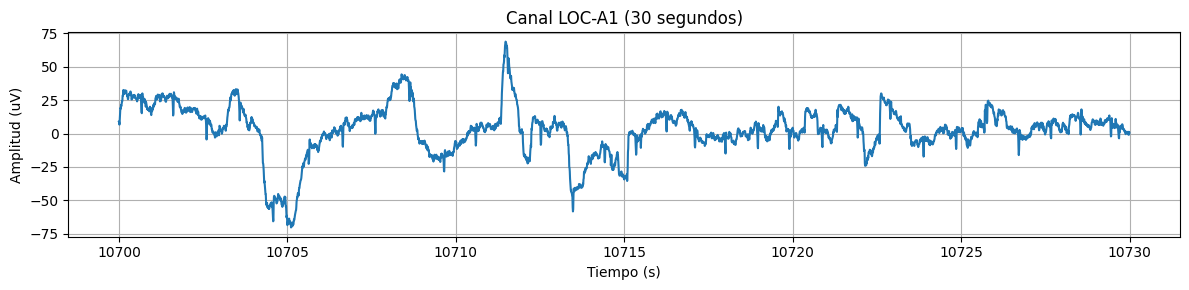

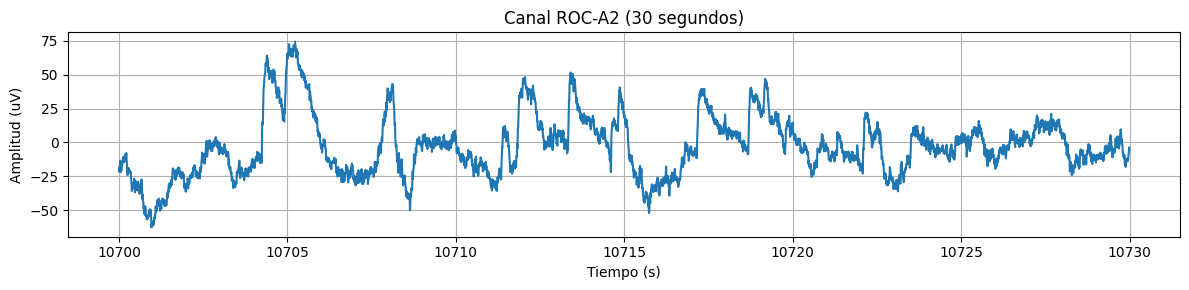

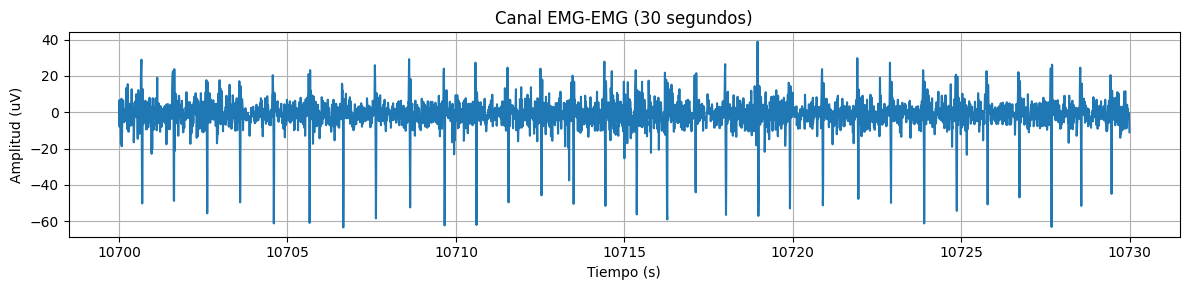

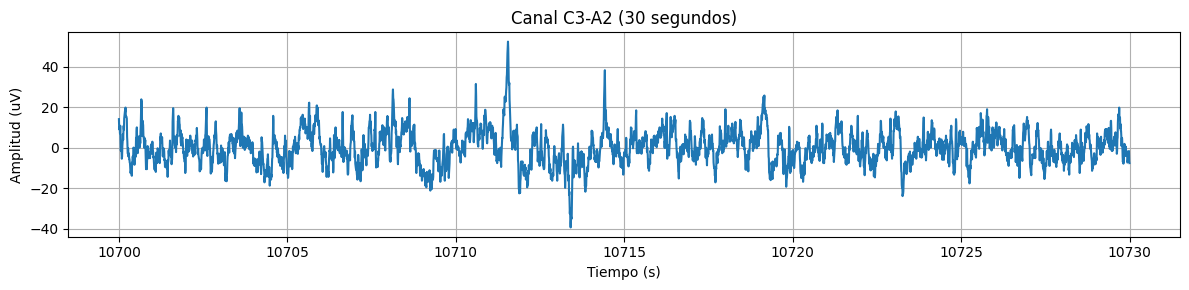

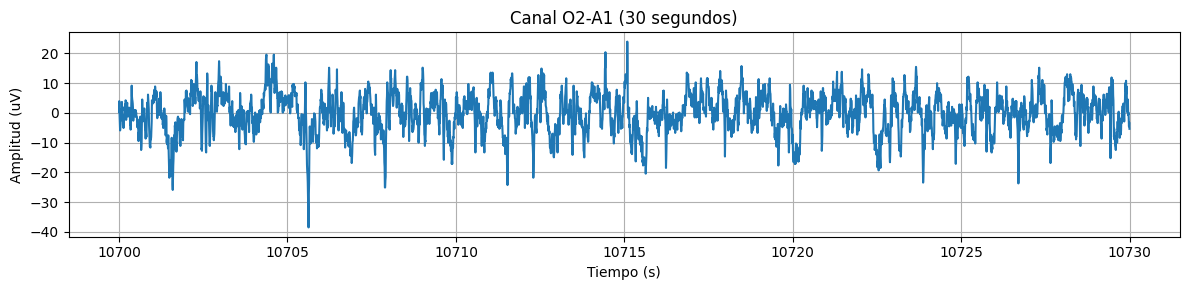

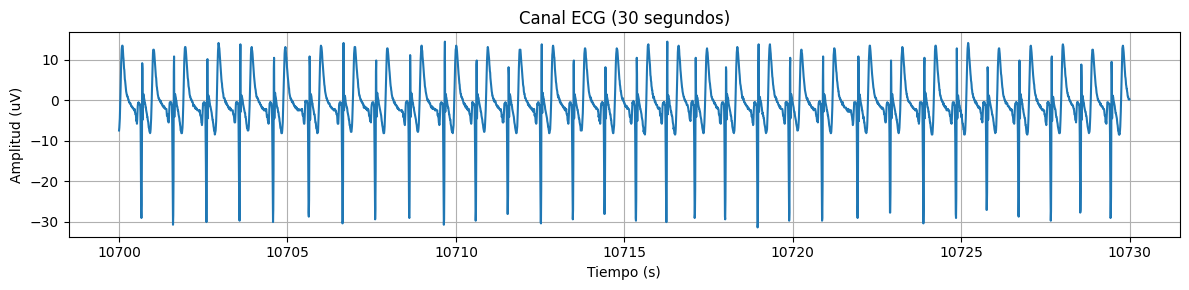

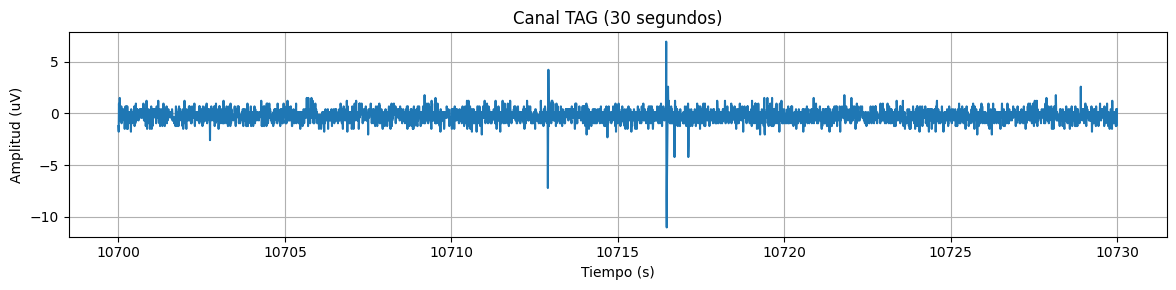

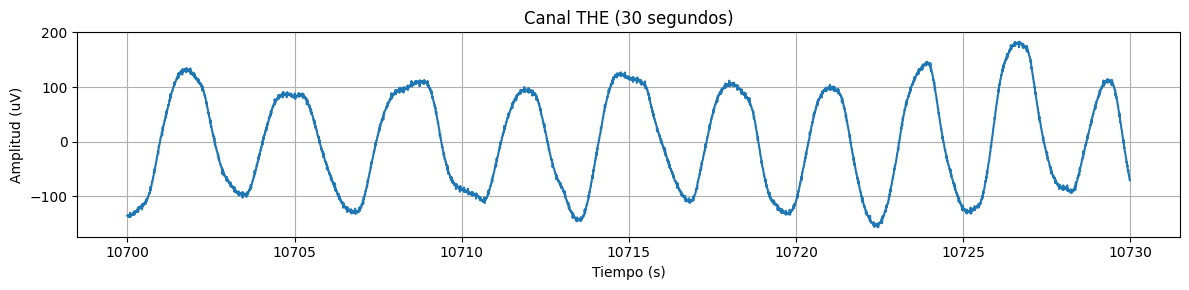

In [7]:
window_sec = 30
#start_sec = 300
#start_sec = np.random.randint(0, int(len(signals[0]) / signal_headers[0]['sample_frequency'] - window_sec))
end_sec = start_sec+ window_sec
fs = signal_headers[0]['sample_frequency']
print(f"\nMostrando {window_sec} segundos de señal desde el segundo {start_sec}.\n")
start_idx = int(start_sec * fs)
end_idx = int((start_sec + window_sec) * fs)

for i, signal in enumerate(signals):
    plt.figure(figsize=(12, 3))
    segment = signal[start_idx:end_idx]
    t = [j / fs for j in range(start_idx, end_idx)]
    plt.plot(t, segment)
    plt.title(f"Canal {signal_headers[i]['label']} ({window_sec} segundos)")
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Amplitud (uV)')
    plt.tight_layout()
    plt.grid(True)
    plt.show()
    

In [8]:
for i, sig in enumerate(signals):
    if signal_headers[i]['label'] == 'LOC-A1':
        eog_left = sig[start_idx:end_idx]
    elif signal_headers[i]['label'] == 'ROC-A2':
        eog_right = sig[start_idx:end_idx]
    elif signal_headers[i]['label'] == 'EMG-EMG':
        emg = sig[start_idx:end_idx]
    elif signal_headers[i]['label'] == 'C3-A2':
        eeg = sig[start_idx:end_idx]

In [9]:
# Helper function
def data_tap(x, M):
  '''
  Genera la matriz de taps MxN
  '''
  N = x.size
  x = np.array(x).reshape(N)
  x_M = np.zeros((N,M))
  
  # Zero-padding
  for m in range(M):
    x_M[m:,m] = x[:N-m]

  return x_M

In [15]:
M = 128 # Filterlength M
mu = 0.0001 # 0.000001 # Learning rate/step size
# t = np.arange(N)

eog_ref = np.subtract(eog_left, eog_right) # Differential EOG signal as reference
emg_ref = emg
eeg = eeg

### 1. EOG Filtering with LMS ###
x_1 = eog_ref 
x_1_tap = data_tap(x_1, M)
d_1 = eeg
# Create LMS-filter
f1 = pa.filters.FilterLMS(n = M, mu = mu, w='zeros') 
y1, e1, w1 = f1.run(d_1,x_1_tap)

### 2. EMG Filtering ###
x2 = emg_ref                # Reference Data: EMG
x2_M = data_tap(x2, M)
# Create NLMS-filter (NLMS is used at the end because it adapts more robustly to varying noise levels (typical in ECG signals))
f2 = pa.filters.FilterLMS(n = M, mu = mu, w='zeros')
y2, e2, w2 = f2.run(e1,x2_M)

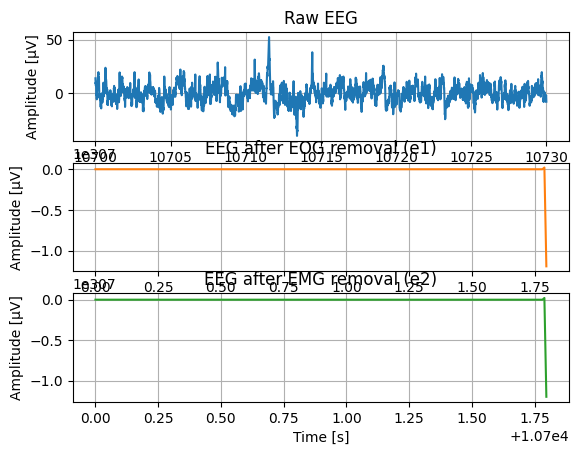

In [16]:
# Plot
plt.figure()

plt.subplot(3,1,1)
plt.plot(t, eeg, color='tab:blue')
plt.title("Raw EEG")
plt.ylabel("Amplitude [µV]")
plt.grid(True)

plt.subplot(3,1,2)
plt.plot(t, e1, color='tab:orange')
plt.title("EEG after EOG removal (e1)")
plt.ylabel("Amplitude [µV]")
plt.grid(True)

plt.subplot(3,1,3)
plt.plot(t, e2, color='tab:green')
plt.title("EEG after EMG removal (e2)")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude [µV]")
plt.grid(True)

# plt.subplot(4,1,4)
# plt.plot(t, eeg, color='tab:blue')
# plt.plot(t, e1, color='tab:orange')
# plt.plot(t, e2, color='tab:green')
# plt.title("all)")
# plt.xlabel("Time [s]")
# plt.ylabel("Amplitude [µV]")
# plt.grid(True)

plt.show()

In [12]:
# Compute PSDs
nperseg = 1024
f_eeg, Pxx_eeg = welch(eeg, fs=fs, nperseg=nperseg)
f_e1, Pxx_e1 = welch(e1, fs=fs, nperseg=nperseg)
f_e2, Pxx_e2 = welch(e2, fs=fs, nperseg=nperseg)

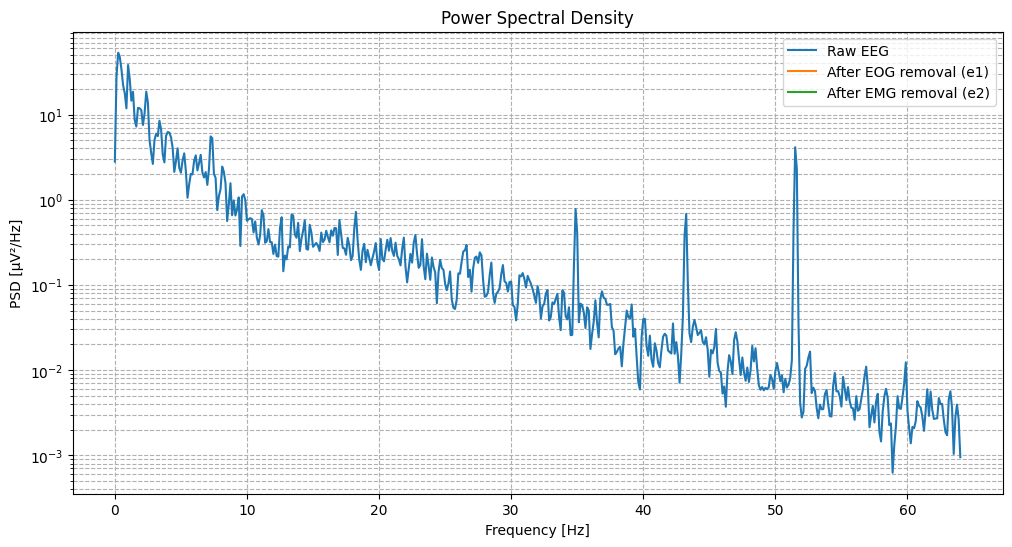

In [13]:
# Plot PSDs
plt.figure(figsize=(12,6))
plt.semilogy(f_eeg, Pxx_eeg, label='Raw EEG')
plt.semilogy(f_e1, Pxx_e1, label='After EOG removal (e1)')
plt.semilogy(f_e2, Pxx_e2, label='After EMG removal (e2)')

plt.title('Power Spectral Density')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD [µV²/Hz]')
plt.legend()
plt.grid(True, which='both', ls='--')
plt.show()

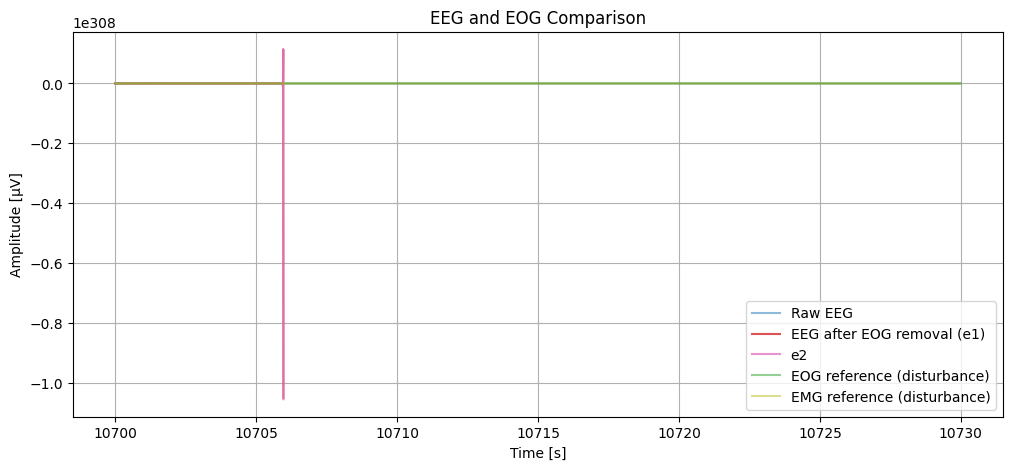

In [14]:
plt.figure(figsize=(12,5))
plt.plot(t, eeg, label='Raw EEG', color='tab:blue', alpha=0.5)
plt.plot(t, e1, label='EEG after EOG removal (e1)', color='tab:red', alpha=0.8)
plt.plot(t, e2, label='e2', color='tab:pink', alpha=0.8)
plt.plot(t, eog_left, label='EOG reference (disturbance)', color='tab:green', alpha=0.5)
plt.plot(t, emg, label='EMG reference (disturbance)', color='tab:olive', alpha=0.5)

plt.title('EEG and EOG Comparison')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude [µV]')
plt.legend()
plt.grid(True)
plt.show()